# Experiment Analysis

This notebook is used to analyze the results of certain experiments which can be found in the pycomex experiment archive located at the ``RESULTS_PATH`` directory.

In [59]:
import os
import time
import json
import datetime
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from rich.pretty import pprint
from pycomex.utils import is_experiment_archive
from pycomex.utils import render_string_table
from pycomex.functional.experiment import Experiment

# This will be the path to the directory in which the notebook is located.
PATH: str = os.getcwd()
# This will have to be the path to the pycomex "results" directory containing the 
# experiment archives of interest.
# HAS TO BE CHANGED, if the analysis is not located in the same directory as the results
# folder.
RESULTS_PATH: str = os.path.join(PATH, 'results')

In [60]:
import datetime


# Filter which experiments will be loaded based on their name and/or parameters.
def select_experiment(experiment_name: str,
                      experiment_metadata: dict,
                      experiment_parameters: dict,
                      ) -> bool:
    main_condition = '__PREFIX__' in experiment_parameters and 'ex_04_a' in experiment_parameters['__PREFIX__']
    
    end_time: float = experiment_metadata['end_time']
    end_datetime = datetime.datetime.fromtimestamp(end_time)
    now = datetime.datetime.now()
    max_delta = datetime.timedelta(weeks=2)
    date_condition = (now - end_datetime) <= max_delta

    return main_condition and date_condition


# Assign a unique key to the experiment based on its data / parameters etc.
# Later on the experiments will be sorted based on this key which will be the 
# key of a dictionary and the values will be a list of all the experiments with 
# that same key.
def sort_experiment(experiment: Experiment) -> tuple:
    *_, encoding, dataset = experiment.metadata['name'].split('__')
    method = experiment.parameters['MODELS'][0]
    num_train = experiment.parameters['NUM_TRAIN']
    
    return (encoding, method, num_train)

### Experiment Discovery

The following cell will first discover all of the previously executed experiment runs which have been archived in the given results directory. It will then print the number of experiments found.

In [61]:
# This list will contain the paths to the individual expeirment *namespaces* which in 
# turn contain the actual individual experiment archives.
experiment_namespace_paths: list[str] = [
    path
    for file_name in os.listdir(RESULTS_PATH)
    if os.path.isdir(path := os.path.join(RESULTS_PATH, file_name))
]

# Subsequently, this list will contain the paths to the individual experiment archives
# folders.
experiment_paths: list[str] = []
for namespace_path in experiment_namespace_paths:
    for dirpath, dirnames, filenames in os.walk(namespace_path):
        if is_experiment_archive(dirpath):
            experiment_paths.append(dirpath)
            dirnames.clear() # Prevents further recursion into subdirectories
        
print(f'✅ found {len(experiment_paths)} experiment archives in {len(experiment_namespace_paths)} namespaces')
pprint(experiment_paths, max_length=3)

✅ found 15171 experiment archives in 32 namespaces


[
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_29__6zGY',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/debug',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_32__Sozn',
│   ... +15168
]

### Experiment Loading

The following cell will then load the experiment runs into memory selectively based on the previously defined ``select_experiment`` function. Only experiments for which the function returns ``True`` will be loaded into memory. The loaded experiments will actually be restored from the archive by loading the parameters as well as the data back into a ``pycomex.experiment.Experiment`` object.

In [62]:
# This list will be populated with the actual Experiment instances which will 
# be loaded from the experiment archive folders.
experiments: list[Experiment] = []

print('Loading experiments from archives...')
time_start: float = time.time()
for experiment_path in experiment_paths:
    
    experiment_identifier: str = os.path.basename(experiment_path)
    
    experiment_data_path = os.path.join(experiment_path, Experiment.DATA_FILE_NAME)
    if not os.path.exists(experiment_data_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no data found')
        continue
    
    experiment_meta_path = os.path.join(experiment_path, Experiment.METADATA_FILE_NAME)
    if not os.path.exists(experiment_meta_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no metadata found')
        continue
    
    with open(experiment_meta_path) as file:
        content = file.read()
        # This will contain the experiment metadata as a dictionary which we can now use to
        # filter for instance.
        experiment_metadata: dict = json.loads(content)
        
    if 'parameters' not in experiment_metadata:
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no parameters found')
        continue
    
    experiment_parameters: dict = {
        param: info['value']
        for param, info in experiment_metadata['parameters'].items()
        if 'value' in info
    }
    
    # Here we apply the filter to determine whether or not the experiment should be included
    # in the analysis.
    condition: bool = select_experiment(
        experiment_name=experiment_metadata['name'],
        experiment_metadata=experiment_metadata,
        experiment_parameters=experiment_parameters
    )
    
    if condition:
        try:
            print(f'   > included experiment "{experiment_identifier}"')
            experiment: Experiment = Experiment.load(experiment_path)
            experiments.append(experiment)
        except Exception as e:
            print(f'   ⚠️ Failed to load experiment "{experiment_identifier}" - Exception: {e}')
            
time_end: float = time.time()
duration: float = time_end - time_start
print(f'✅ Loaded {len(experiments)} experiments in {duration:.2f} seconds')

Loading experiments from archives...
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "test__18_07_2025__16_15__nC6j" - no data found
   ⚠️ Skipping experiment "ex_04_e__15_01_2025__09_00__MnVH" - no data found
   ⚠️ Skipping experiment "test__18_07_2025__16_14__MB3w" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_04_d__06_08_2025__13_15__ja1g" - no data found
   ⚠️ Skipping experiment "hyperopt_b__16_01_2025__08_56__Cv1n" - no data found
   > included experiment "ex_04_a__02_08_2025__12_35__W8nN"
   ⚠️ Skipping experiment "ex_03_b__31_07_2025__11_49__M1Nv" - no data found
   > included experiment "ex_04_a__29_07_2025__01_02__Izdm"
   > included experiment "ex_04_a__29_07_2025__00_57__C4QP"
   > included experiment "ex_04_a__29_07_2025__01_23__6cZL"
   > included experiment "ex_04_a__29_07_2025__00_48__f19u"
   >

In [63]:
example_experiment: Experiment = experiments[0] if experiments else None
pprint(example_experiment.data, max_length=10)

{
│   'indices': {
│   │   'train': [89810, 59259, 121058, 115730, 124624, 59535, 65342, 116038, 21217, 88794, ... +6990],
│   │   'val': [53555, 104202, 117846, 20926, 127330, 74659, 114920, 129873, 112192, 56869],
│   │   'test': [97645, 57944, 103831, 102044, 82760, 45934, 133396, 1931, 25719, 34044, ... +13378]
│   },
│   'metrics': {
│   │   'test_k_neighbors': {'r2': 0.7784824024520771, 'mse': 0.0004982250683298475, 'mae': 0.016743858679414404}
│   }
}

### Experiment Sorting

The following cell will sort the - currently still unsorted - experiment list by a custom criteria defined in the ``sort_experiments`` function. This is done by putting all the experiments into the same list for which this function returns the same index tuple. The result is the ``key_experiment_map`` dictionary data structure which maps the index tuple to a list of experiments.

In [64]:
# This will be a dictionary mapping the unique key of the experiment to a list of
# experiments which share that key. This will allow us to group experiments based on
# their parameters or other attributes.
key_experiment_map: dict[tuple, list[Experiment]] = defaultdict(list)

for experiment in experiments:
    key: tuple = sort_experiment(experiment)
    key_experiment_map[key].append(experiment)
    
key_experiment_map = dict(sorted(key_experiment_map.items(), key=lambda item: item[0][0] + item[0][1] + f'{int(item[0][2]):06d}'))
pprint(key_experiment_map, max_length=3)

{
│   ('fp', 'k_neighbors', 10): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9fe61aa50>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9fd405510>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9fa4b6a50>
│   ],
│   ('fp', 'k_neighbors', 50): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9ff532690>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9fae9b590>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9fbac24d0>
│   ],
│   ('fp', 'k_neighbors', 100): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9fda08850>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9fc766a50>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7cb9fad81c10>
│   ],
│   ... +76
}

### Experiment Result Table

The following cell illustrates how to create a table from the aggregated results of many loaded experiments, which is a common use case of the analysis.

In [65]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Encoding', 'Method', 'Num Train', 'Result']

# This data structure will hold the (encoding, dataset, method) tuple as keys and the metric
# values as a list value.
key_values_map = defaultdict(list)

for (encoding, method, num_train), _experiments in key_experiment_map.items():
    
    example_experiment = _experiments[0]
    if example_experiment.parameters['DATASET_TYPE'] == 'regression':
        metric = 'r2'
    else:
        metric = 'f1'
        
    values = [exp.data['metrics'][f'test_{method}'][metric] for exp in _experiments if 'metrics' in exp.data]
    mean_value = np.mean(values)
    std_value = np.std(values)
    
    table.add_row([
        encoding,
        method,
        num_train,
        f'{mean_value:.2f} ± {std_value:.2f}',
    ])
    
    key_values_map[(encoding, method, num_train)] = values
    
print(table.get_string())

+----------+---------------+-----------+--------------+
| Encoding |     Method    | Num Train |    Result    |
+----------+---------------+-----------+--------------+
|    fp    |  k_neighbors  |     10    | -0.09 ± 0.14 |
|    fp    |  k_neighbors  |     50    | 0.20 ± 0.13  |
|    fp    |  k_neighbors  |    100    | 0.27 ± 0.14  |
|    fp    |  k_neighbors  |    200    | -0.03 ± 0.47 |
|    fp    |  k_neighbors  |    500    | -0.15 ± 0.39 |
|    fp    |  k_neighbors  |    1000   | 0.05 ± 0.34  |
|    fp    |  k_neighbors  |    2000   | 0.16 ± 0.25  |
|    fp    |  k_neighbors  |    5000   | 0.32 ± 0.24  |
|    fp    |  k_neighbors  |    7000   | 0.42 ± 0.18  |
|    fp    |  k_neighbors  |   10000   | 0.52 ± 0.11  |
|    fp    |  k_neighbors  |   50000   | 0.80 ± 0.00  |
|    fp    |  k_neighbors  |   100000  | 0.85 ± 0.00  |
|    fp    |   neural_net  |     10    | 0.12 ± 0.08  |
|    fp    |   neural_net  |     50    | 0.38 ± 0.04  |
|    fp    |   neural_net  |    100    | 0.44 ± 

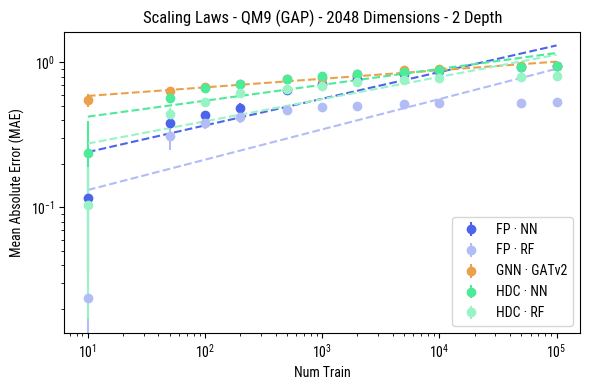

In [66]:
import numpy as np
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Prepare the data for plotting
import matplotlib.pyplot as plt
plt.style.use('default')

plt.rcParams['font.family'] = 'Roboto Condensed'

plt.figure(figsize=(6, 4))

exclude_keys = [('fp', 'k_neighbors'), ('hdc', 'k_neighbors')]

# Mapping for pretty labels for each (encoding, method) combination
key_label_map = defaultdict(lambda: 'Unknown Method')
key_label_map.update({
    ('fp', 'neural_net'): 'FP · NN',
    ('fp', 'random_forest'): 'FP · RF',
    ('gnn', 'gatv2'): 'GNN · GATv2',
    ('hdc', 'neural_net'): 'HDC · NN',
    ('hdc', 'random_forest'): 'HDC · RF',
})

# Define a color map for each (encoding, method) combination
key_color_map = defaultdict(lambda: '#000000')  # Default color if not specified
key_color_map.update({
    ('fp', 'neural_net'): '#4C64EB',        
    ('fp', 'random_forest'): '#B2BDF6',     
    ('gnn', 'gatv2'): '#EBA14C', 
    ('gnn', 'gin'): '#EBA14C',  # Assuming GIN is also a GNN method           
    ('hdc', 'neural_net'): '#4CEB99',       
    ('hdc', 'random_forest'): '#99F4C5',    
})
color_map = key_color_map

# Group keys by (encoding, method)
grouped = defaultdict(list)
for (encoding, method, num_train), vals in key_values_map.items():
    grouped[(encoding, method)].append((num_train, vals))

# colors = plt.cm.tab10.colors
# color_map = {}
# for idx, combo in enumerate(grouped.keys()):
#     color_map[combo] = colors[idx % len(colors)]

for (encoding, method), items in grouped.items():
    if (encoding, method) in exclude_keys:
        continue
    
    # Sort by num_train
    items = sorted(items, key=lambda x: x[0])
    num_trains = np.array([num_train for num_train, _ in items])
    means = np.array([np.mean(vals) for _, vals in items])
    stds = np.array([np.std(vals) for _, vals in items])

    label = key_label_map[(encoding, method)]
    plt.errorbar(num_trains, means, yerr=stds, fmt='o', label=label, color=color_map[(encoding, method)])

    # Linear fit in log-log space
    log_x = np.log10(num_trains)
    log_y = np.log10(means)
    coeffs = np.polyfit(log_x, log_y, 1)
    fit_y = np.power(10, np.polyval(coeffs, log_x))
    plt.plot(num_trains, fit_y, '--', color=color_map[(encoding, method)])

import random
example_experiment = random.choice(experiments)
if 'FINGERPRINT_SIZE' in example_experiment.parameters:
    embedding_size = example_experiment.parameters['FINGERPRINT_SIZE']
else:
    embedding_size = example_experiment.parameters.get('EMBEDDING_SIZE', 'unknown')

dataset_name = example_experiment.parameters.get('DATASET_NAME', 'unknown')
dataset_label_map = {   
    'qm9_smiles': 'QM9 (GAP)',
    'aqsoldb': 'AqSolDB',
    'zinc250': 'ZINC250k (QED)',
}

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Num Train')
plt.ylabel('Mean Absolute Error (MAE)')

plt.title(f'Scaling Laws - {dataset_label_map[dataset_name]} - {embedding_size} Dimensions - 2 Depth')
plt.legend()
plt.tight_layout()
plt.show()

